# *Machine learning*

Gracias a que el conjunto de datos de Herlev contiene un excel con datos numéricos y características extraídas de las imágenes, podemos entrenar algoritmos de Machine Learning como *benchmark* para comaprar el rendimiento de los modelos posteriores. A continuación veremos una rápida implementación de ML y aprenderemos como se evalúan los modelos.

## ¿Qué es Machine Learning?

Es un subconjunto de la **Inteligencia Artificial** que trata del desarrollo de algoritmos para permitir que las computadoras aprendan de datos y experiencias pasadas. Es un área multidisciplinaria que involucra áreas del saber como la matemática, cibernética, ciencias de la computación, optimización, lenguaje, etcétera. 

![](imagenes/ML.jpg "")

Difiere de la programación tradicional y otras áreas de la IA (como los Sistemas Expertos) de manera fundamental, cambiando el paradigma y permitiendo a los modelos generar las reglas por si mismos utilizando datos referentes al fenómeno modelado. Es un salto enorme con respecto a los sistemas al reducir la complejidad de desarrollo.

![El paradigma de Machine Learning y la generación de reglas](imagenes/paradigma.png "Paradigma de Machine Learning")

El Machine Learning se divide en tres áreas. Nosotros nos enfocaremos en el área de aprendizaje supervisado

![](imagenes/tipos_ml.png "")

La forma más fácil de entender el aprendizaje supervisado, es tener un conjunto de datos en forma de tabla. Donde se tienen $ X_{n}$ variables de entrada y una (o varias depende del problema) variable de salida $Y$. La tabla muestra un problema de clasificación. Podemos ver que las columnas se componen de diferentes tipos de datos, tenemos variables continuas, discretas, booleanas y categóricas. La capacidad de operar con columnas de distinto tipo es una de las características que distinguen al Machine Learning del aprendizaje estadístico tradicional.

| X1   | x2        | x3      | Y      |
|------|-----------|---------|--------|
| 1.1  | Verdadero | "Tipo1" | Clase3 |
| 5.4  | Falso     | "Tipo4" | Clase2 |
| 9.1  | Falso     | "Tipo1" | Clase1 |
| 12.0 | Verdadero | "Tipo3" | Clase1 |
| 9.3  | Falso     | "Tipo2" | ?????? |

Al entrenar un modelo matemático, lo que buscamos es encontrar o aproximar una función matemática $F(X)$ tal que nos de los valores de $Y$. Para un problema de clasificación, esto se puede entender como encontrar una frontera entre dos conjuntos de datos. En dos dimensiones, esto es sumamente fácil, en tres, un poco más complicado pero fácil de visualizar. Podemos entender ahora la complejidad cuando se tratan con datos de muchas columnas, es decir, de múltiples dimensiones.

![](imagenes/svm.gif "")

Ahora veremos el mismo proceso con datos de forma más compleja.

![](imagenes/decision.png "")

Una de las partes más importantes del Machine Learning, es la elección y creación de las características más importantes del problema que nos permitan encontrar un modelo que lo represente correctamente, es decir, buscar las columnas que nos permitan entrenar un algoritmo. Este proceso se conoce como *Feature Engineering* y es sumamente complejo y requiere mucho esfuerzo.

Hay que tener en cuenta que no existe un algoritmo que sea el mejor para todos los tipos de problema, es decir, ninguno es mejor que otro, por ello se tienen que explorar varios algoritmos y analizar su rendimiento para cada problema o conjunto de datos.

In [1]:
# !pip install pycm

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%matplotlib inline
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from pycm import ConfusionMatrix

plt.rcParams.update({'figure.figsize': (15,15)})

SEED = 199510

np.random.seed(SEED)


ROOT_DIR = pathlib.Path().resolve().parent

# Descomentar para correr en Google Colab usando Drive
# ROOT_DIR = pathlib.Path("drive/MyDrive/curso_cisc_2022")

DATA_DIR = ROOT_DIR / "Data" / "smear2005"
print(ROOT_DIR)

import utils

C:\Users\marco\Documents\Trabajo\Academia\curso_cisc_2022


In [4]:
df = pd.read_csv(f'{DATA_DIR}/dataset.csv')
dataset = df.drop(["Class", "ID", "Class_cat_7", "Class_num_7", "Class_cat_2", "Class_num_2", "filename"], axis=1)

## Breve análisis

Generalmente, al empezar la creación de modelos, se realiza un análisis estadístico exhaustivo para determinar las propiedades intrínsecas de los datos. Esto nos ayuda a determinar la familia de algoritmos que se podrían aplicar y otras cuestiones importantes que se tienen que averiguar para entrenar algoritmos de manera correcta. A continuación veremos algunos ejemplos de este proceso.

### Gráfica de caja

En la gráfica de caja podemos visualizar los cuartiles y entender como operan los conjuntos numéricos de cada columna.

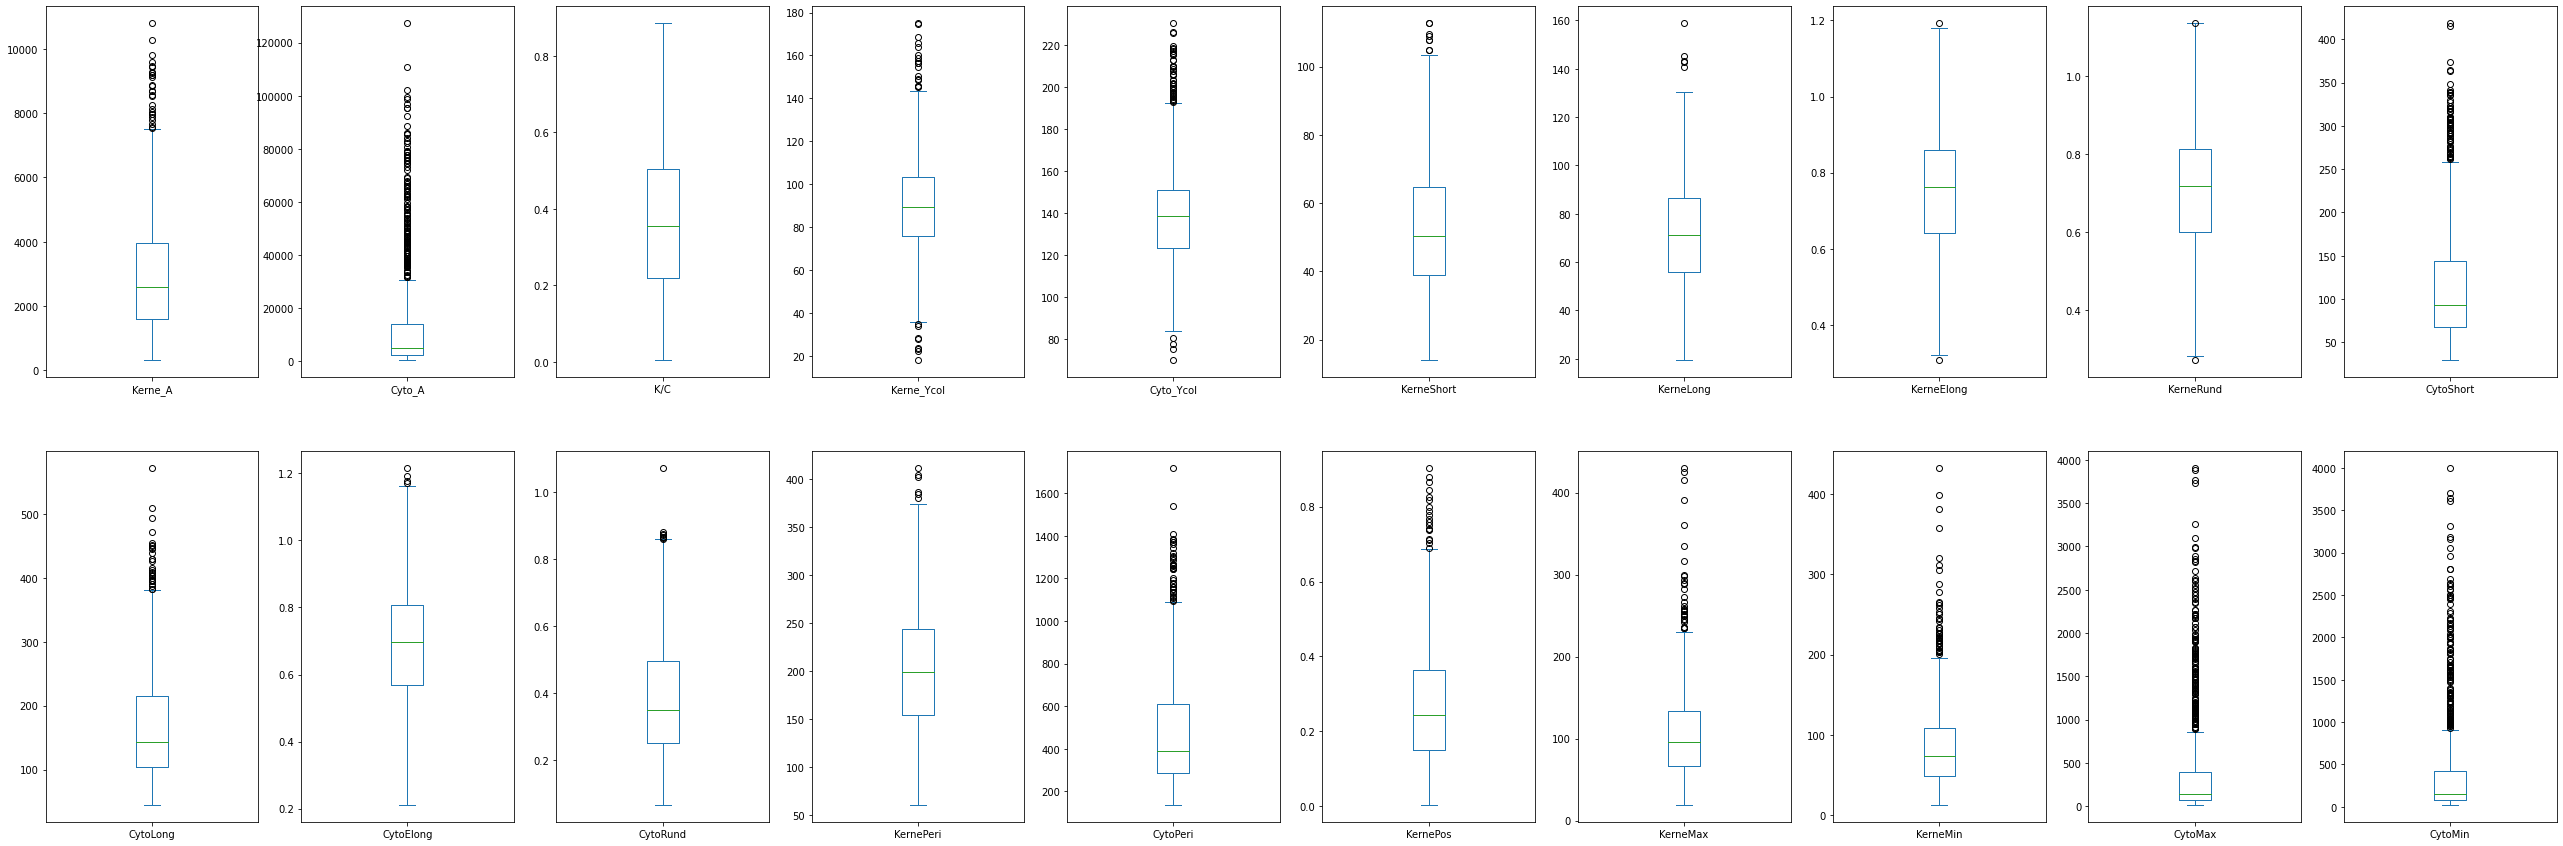

In [5]:
dataset.plot(kind='box', subplots=True, layout=(2,10), sharex=False, sharey=False, figsize=(45,15));

### Correlación

El análisis de correlación nos dice si existe una relación lineal y proporcionalidad entre las variables. 

In [6]:
corr = dataset.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

### Histogramas

Los histogramas nos permiten determinar la distribución de los datos, con esto podemos saber si los datos son normales o no. Los datos distribuidos de manera Gaussiana son más fáciles de modelar.

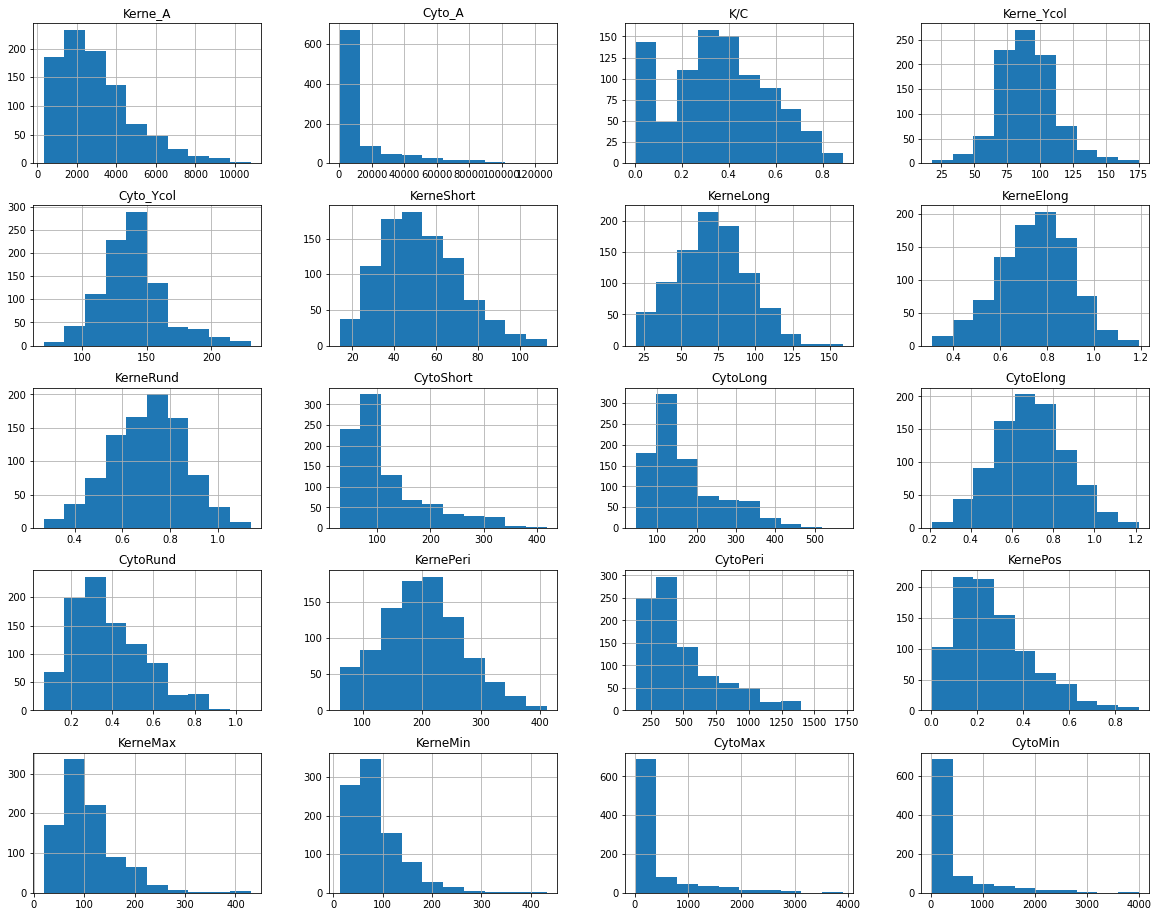

In [7]:
dataset.hist(figsize=(20,16));

### Matriz de dispersión

El diagrama de dispersión conjuga ambos conceptos, mostrando en la diagonal la forma de la distribución y el gráfico de dispersión para todas las columnas. 

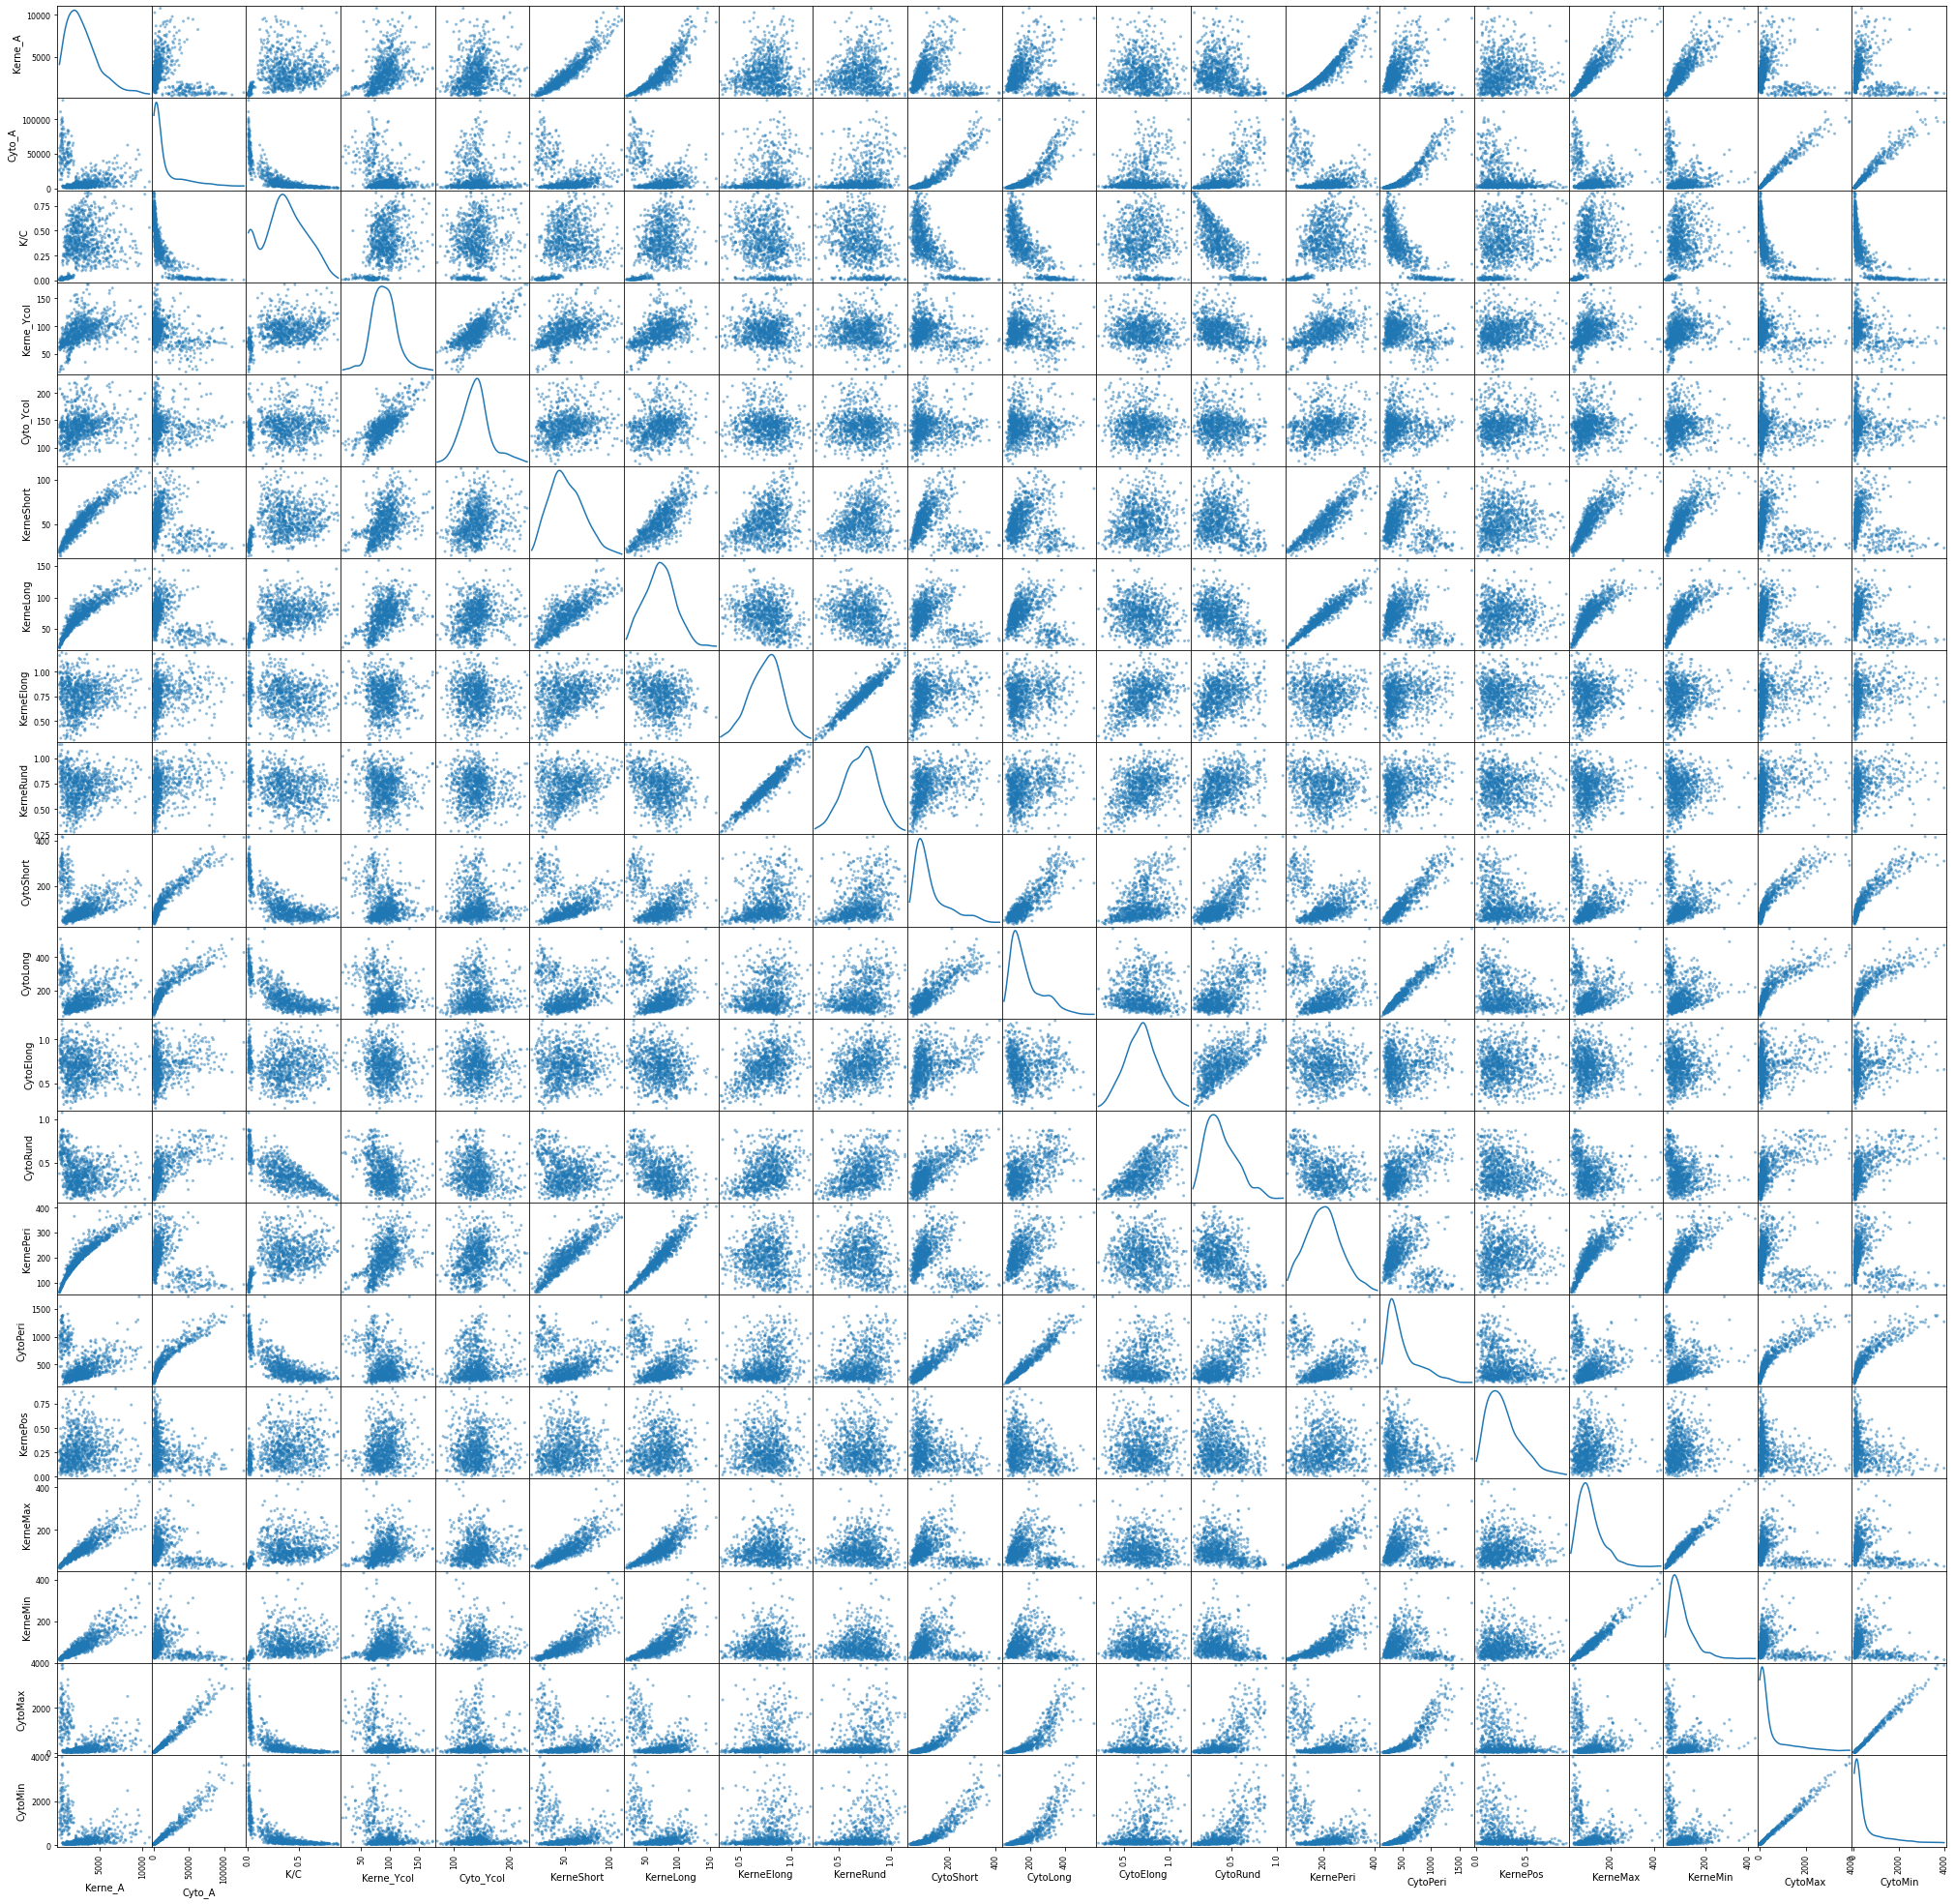

In [8]:
pd.plotting.scatter_matrix(dataset, figsize=(35,35), diagonal="kde");

##  División de datos para entrenamiento y validación cruzada

Para realizar objetivamente el entrenamiento de cualquier modelo y poder evaluar su rendimiento sin sesgos, se tienen que dividir los datos en dos o tres conjuntos, dependiendo de el caso. El primer conjunto, el de entrenamiento, servirá para entrenar el algoritmo; el segundo conjunto, validación, sirve para determinar el rendimiento del algoritmo y ajustar sus parámetros para incrementarlo en dado caso; el último, el conjunto de pruebas, nos permite evaluar el poder de generalización.

El método correcto para evaluar un modelo, es separar los datos en entrenamiento y pruebas. Posteriormente, se aplicará la técnica de Validación Cruzada, que divide los datos de entrenamiento en dos subconjuntos, uno usado para entrenar y otro para validar. Esto se realiza secuencialmente K veces en el método de Validación Cruzada de K iteraciones. Para determinar el rendimiento, se toma la media de cada uno de los experimentos, obteniendo así una estimación del rendimiento real del modelo y su poder de generalización

La ventaja de esta técnica por sobre la división en tres conjuntos, es que se reducen la cantidad de datos disponibles para el entrenamiento. 

![](imagenes/cross.png "Validación cruzada")

Dejando atrás teorías estadísticas de aprendizaje computacional, separar un conjunto para evaluación y otro para calibración, evita que ajustemos las características de nuestros modelos a los conjuntos específicos de entrenamiento y validación. De esta forma nos aseguramos medir correctamente su poder de generalización.

## Overfitting

Cuando un modelo se ajusta perfectamente al conjunto de entrenamiento pero tiene rendimiento pobre en el conjunto de prueba, se dice que el algoritmo está sobreajustado o que presenta overfitting. El modelo es incapaz de generalizar, solo aprendió el conjunto de entrenamiento y no pudo capturar correctamente el fenómeno subyacente que produjo los datos. Por ejemplo, una persona que se aprende de memoria los resultados de los problemas en un libro matemático pero es incapaz de resolver ejercicios de otros libros.

El underfitting o infrajuste es cuando un modelo es incapaz de capturar siquiera el comportamiento del conjunto de datos.

![](imagenes/underfit.png "Sobreajuste")


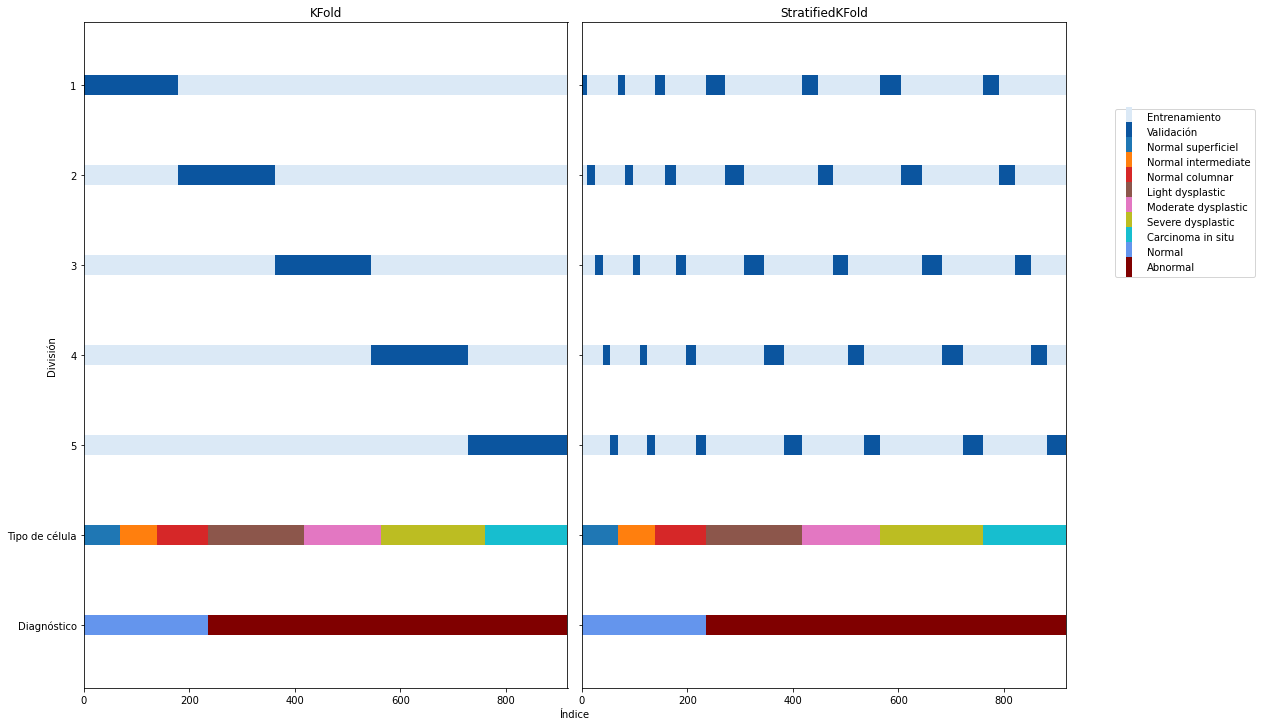

In [10]:
KFOLDS = 5

df_kfold = df.sort_values(by=["Class_num_7"])

kf = KFold(n_splits=KFOLDS)

skf = StratifiedKFold(n_splits=KFOLDS)

utils.plot_kfold_subplot(
    kf,
    skf,
    df_kfold["ID"],
    df_kfold["Class_cat_7"],
    n_splits=KFOLDS,
    lw=20,
    figsize=(15, 10),
)


## Evaluación de un modelo de clasificación

Para evaluar clasificación, se usa una representación conocida como *matriz de confusión*, donde cada fila representa la clase real y las columnas las predicciones. Permite una evaluación visual e intuitiva sobre el rendimiento real de un algoritmo, inclusive cuando existe un gran desbalanceo de datos. Está relacionada directamente con los tipos de error encontrados en las pruebas de hipótesis. De esta matriz, se derivan varias cantidades que permiten generar múltiples métricas de evaluación dependiendo del tipo de error relevante para la tarea en cuestión.

![](imagenes/confusion.png "Matriz de confusión")

Para las evaluaciones, usaremos el módulo PyCM que es una de las mejores implementaciones, tanto por lo completo en métricas como el potencial explicativo que ofrece: <https://www.pycm.ir/doc/index.html>

### Algunas métricas importantes

Dependiendo de la tarea, el modelo y las características de los datos, se tiene que evaluar el rendimiento de la manera más significativa posible. Para el área médica, es importante conocer la forma en que nuestros algoritmos se equivocan: no es lo mismo clasificar una muestra como positiva o negativa si lo que se busca es cáncer, gripe o diabetes. En el caso de enfermedades graves, es de suma importancia que las tasa de falsos negativos sean muy bajas.

Como existen muchas métricas de evaluación para modelos de clasificación, algunas sumamente significativas y otras superficiales, nos enfocaremos en las siguientes para tener una representación cercana a la realidad del proceso. En la videa real, serán los expertos del dominio (médicos), los que determinen cuales métricas son las más importantes para la tarea.

#### Accuracy (Exactitud)

Es el número de predicciones correctas sobre todas las predicciones.

$$ ACC = \frac{TP + TN}{P + N} = \frac{TP + TN}{TP + TN + FP + FN} $$

Esta métrica es usada bastante pero tiene ciertas condiciones para su aplicación, por ejemplo, si estamos trabajando con enfermedades raras, donde el conjunto de datos está desbalanceado en una proporción de 95% negativo y 5% positivo, si el sistema es capaz de acertar correctamente todos los negativos, tendrá $ACC = 95\%$. Podría parecer que el modelo tiene un rendimiento excelente, sin embargo, esto no nos dice mucho sobre el rendimiento real sobre la clase significativa, en este caso, el poder predictivo sobre los positivos.

#### Precision y Recall (Precision y exhaustividad)

Recall, TPR (True Positive Rate) o Sensitivity mide la proporción de positivos que fueron identificados correctamente.

$$ TPR = Recall = Sensitivity = \frac{TP}{P} = \frac{TP}{TP + FN} $$

Precision o PPV (Positive Predictive Value), es la proporción de positivos que corresponden a la presencia de la condición.

$$ PPV = Precision = \frac{TP}{TP + FP} $$

![](imagenes/precision_recall.png "")

#### Specificity (Especificidad)

También conocido como TNR (True Negative Rate), mide la proporción de negativos que fueron identificados correctamente.

$$ TNR = Specificity = \frac{TN}{N} = \frac{TN}{TN + FP} $$

#### $F_{1}$ score (Valor-F)

El Valor-F representa el promedio armónico entre Precision y Recall, conjugando ambas métricas en un solo valor.

$$ F_{1} = \frac{2}{recall^{-1} + precision^{-1}} = 2\frac{precision \dot recall}{precision + recall} = \frac{tp}{tp + \frac{1}{2}(fp+fn)} $$

## Entrenamiento de algoritmos de Machine Learning

El módulo de Python indicado para la creación y entrenamiento de modelos de ML es ***scikit-learn***: <https://scikit-learn.org/stable/>. Creaco en el 2007 por David Cournapeau, contiene todas las funciones necesarias para generar modelos que pueden ser usados en la vida real. Tiene las siguientes funciones principales:

1. Clasificación.
2. Regresión.
3. Agrupamiento.
4. Reducción de dimensionalidad.
5. Selección de modelos.
6. Preprocesamiento.

Trataremos los dos casos: binario y multiclase.

Entrenaremos y compararemos 8 algoritmos distintos para determinar el mejor para cada caso. Los algoritmos son:

- Logistic Regression.
- LInear Discriminant Analysis.
- K-Neighbors Classifier.
- Decision Tree Classifier.
- Gaussian Naive Bayer.
- Support Vector Machine.
- Multilayer Perceptron Classificer.


### Problema binario

Procedemos a entrenar secuencialmente los algoritmos utilizando la técnica de validación cruzada. Capturamos los resultados y calculamos media y desviación.

In [30]:
X = dataset.values
y = df["Class_cat_2"].values
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

print(f"X_train: {X_train.shape}")
print(f"X_validation: {X_validation.shape}")

X_train: (733, 20)
X_validation: (184, 20)


In [11]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('MLP1', MLPClassifier()))
models.append(('MLP2', MLPClassifier(hidden_layer_sizes=(100,100))))

results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=KFOLDS, random_state=SEED, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print(f"{name}: {cv_results.mean()} +/- ({cv_results.std()})")

LR: 0.9371899296556829 +/- (0.03423286896635149)
LDA: 0.9359311366160682 +/- (0.025864767296950718)
KNN: 0.90312847093669 +/- (0.02155556499456821)
CART: 0.9141058867086265 +/- (0.034998205819794646)
NB: 0.9127730470196223 +/- (0.02779571563446348)
SVM: 0.7367271380970012 +/- (0.00458087907307691)
MLP1: 0.8841169937060348 +/- (0.05380999866078904)
MLP2: 0.9045168456127362 +/- (0.03884440224125249)


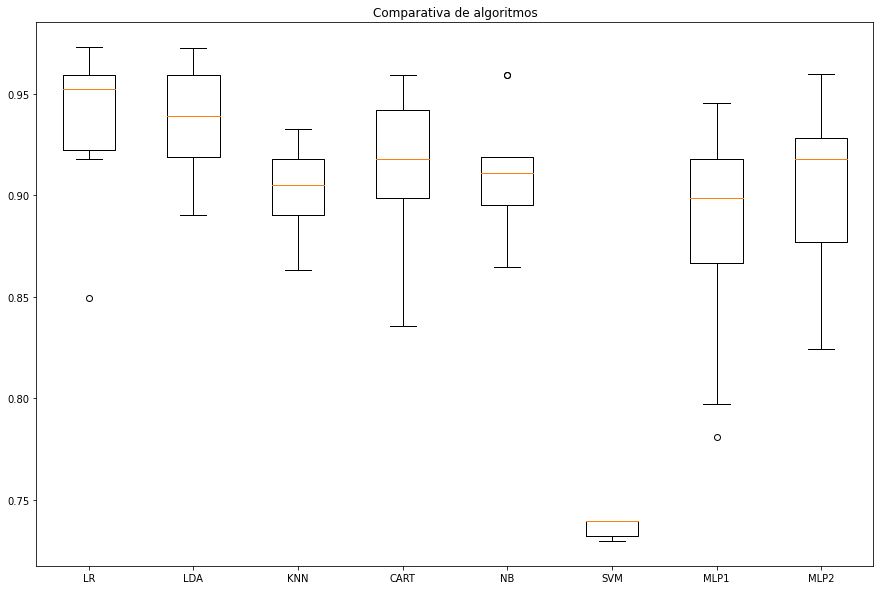

In [12]:
plt.figure(figsize=(15,10))
plt.boxplot(results, labels=names)
plt.title('Comparativa de algoritmos')
plt.show()

In [13]:
model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

In [14]:
df_pred = pd.DataFrame({"Real": Y_validation, "Pred": predictions})
df_pred = df_pred.replace(utils.map_2_classes)
df_error = df_pred[df_pred["Real"] != df_pred["Pred"]]
print(len(df_error.index))

12


In [15]:
df_error.groupby("Pred").size()

Pred
anormal    6
normal     6
dtype: int64

In [16]:
cm = ConfusionMatrix(actual_vector=Y_validation, predict_vector=predictions)
print(cm)

Predict       anormal       normal        
Actual
anormal       129           6             

normal        6             43            





Overall Statistics : 

95% CI                                                            (0.89911,0.97046)
ACC Macro                                                         0.93478
ARI                                                               0.74302
AUNP                                                              0.91655
AUNU                                                              0.91655
Bangdiwala B                                                      0.89644
Bennett S                                                         0.86957
CBA                                                               0.91655
CSI                                                               0.83311
Chi-Squared                                                       127.70825
Chi-Squared DF                                                    1
Conditional Ent

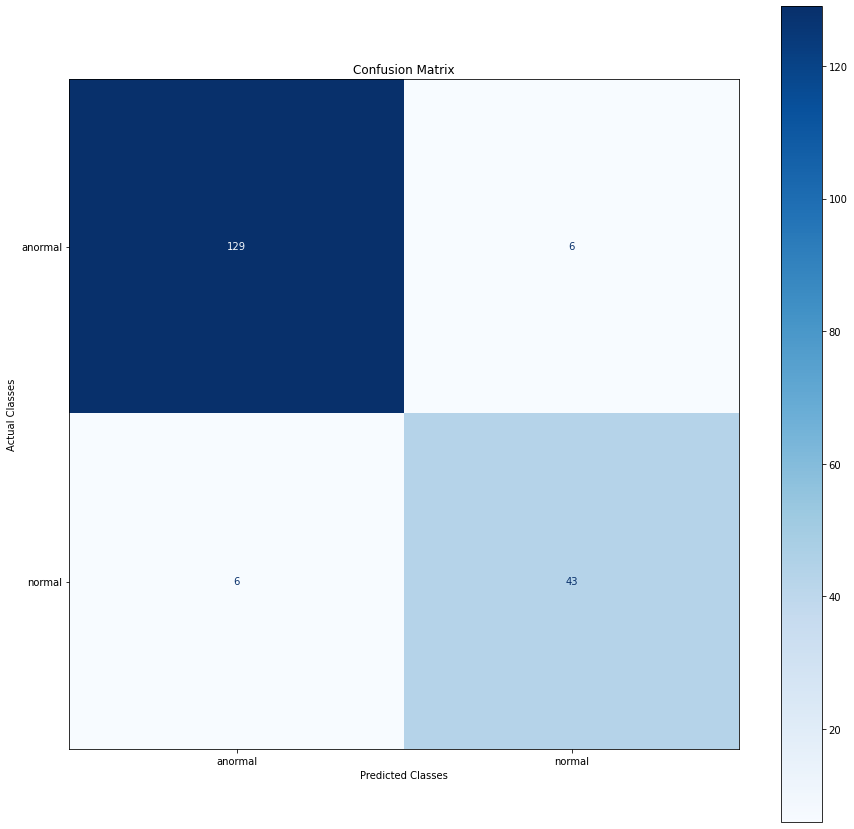

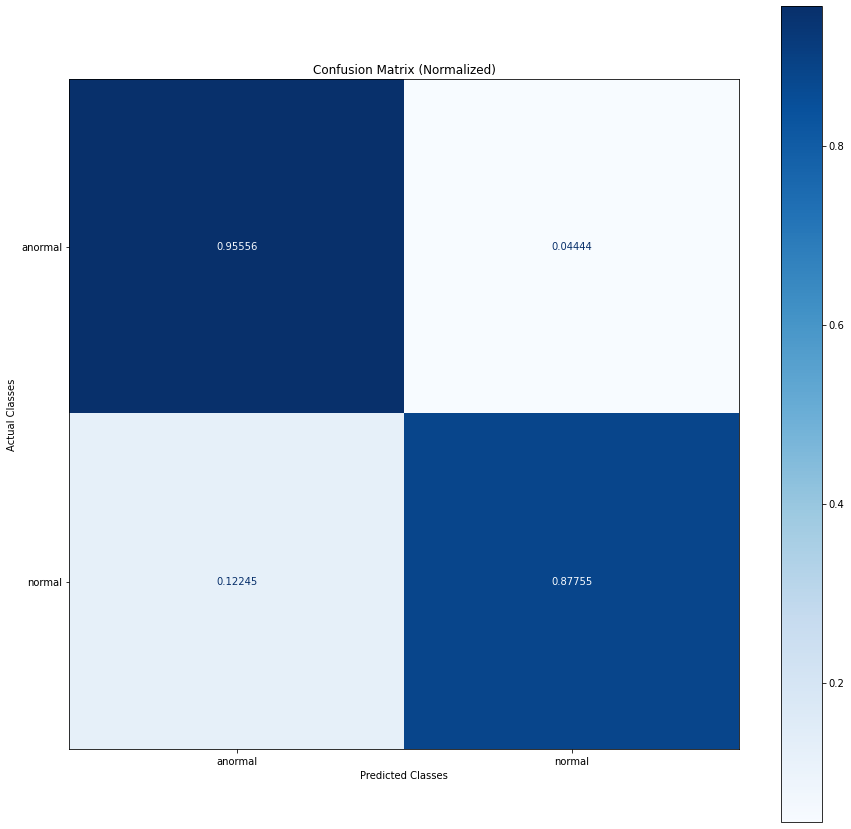

In [17]:
cm.plot(cmap=plt.cm.Blues, number_label=True);
cm.plot(cmap=plt.cm.Blues, number_label=True, normalized=True);

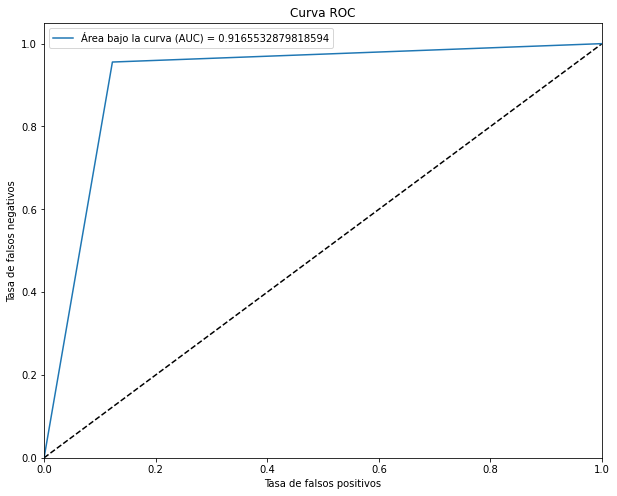

In [18]:
utils.plot_roc(df_pred)

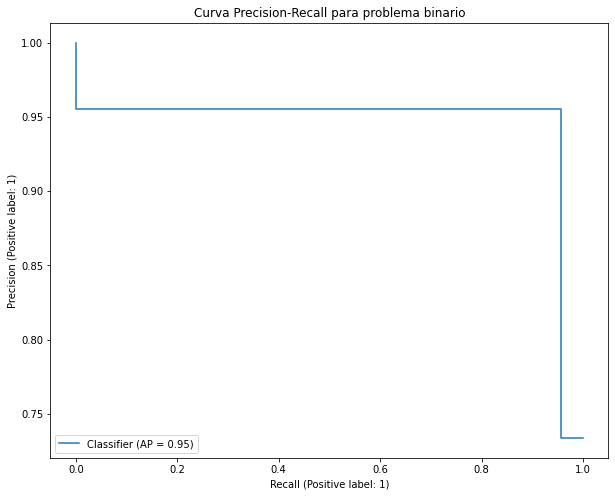

In [19]:
utils.plot_precision_recall(df_pred)

In [20]:
X = dataset.values
y = df["Class_cat_7"].values
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

In [21]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('MLP1', MLPClassifier()))
models.append(('MLP2', MLPClassifier(hidden_layer_sizes=(100,100))))
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=KFOLDS, random_state=SEED, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print(f"{name}: {cv_results.mean()} +/- ({cv_results.std()})")

LR: 0.6328767123287672 +/- (0.035469987494618334)
LDA: 0.6424102184376157 +/- (0.06254192177790206)
KNN: 0.512754535357275 +/- (0.051119106736701295)
CART: 0.5224361347649018 +/- (0.05033925189147595)
NB: 0.5386338393187708 +/- (0.05187039470702751)
SVM: 0.2141984450203628 +/- (0.0064522902995275315)
MLP1: 0.5128100703443168 +/- (0.049440543571950636)
MLP2: 0.48983709737134395 +/- (0.062223557155518465)


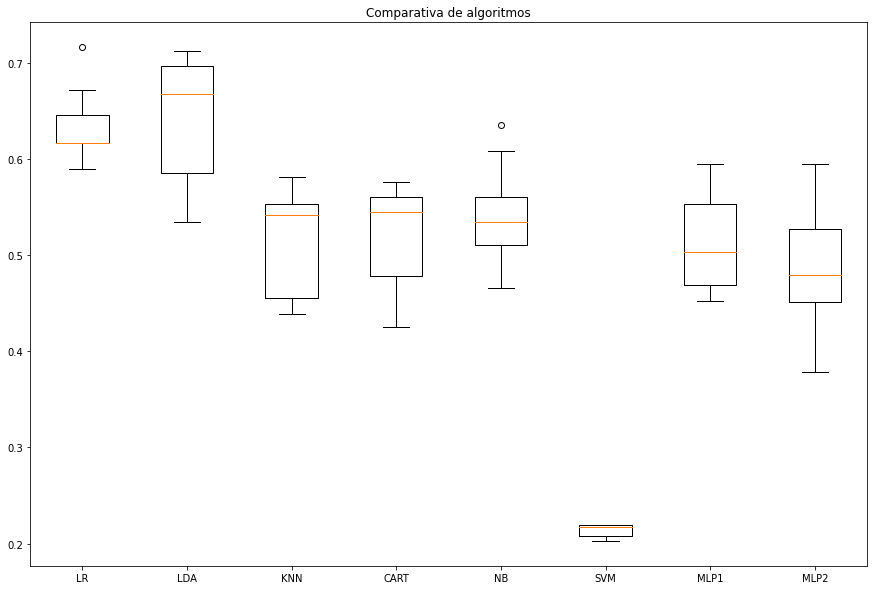

In [22]:
plt.figure(figsize=(15,10))
plt.boxplot(results, labels=names)
plt.title('Comparativa de algoritmos')
plt.show()

In [23]:
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

In [24]:
df_pred = pd.DataFrame({"Real": Y_validation, "Pred": predictions})
df_pred = df_pred.replace(utils.map_2_classes)
df_error = df_pred[df_pred["Real"] != df_pred["Pred"]]
print(len(df_error.index))

70


In [25]:
df_error.groupby("Pred").size()

Pred
carcinoma_in_situ      12
light_dysplastic       11
moderate_dysplastic    13
normal_columnar         9
normal_intermediate     3
normal_superficiel      3
severe_dysplastic      19
dtype: int64

In [26]:
cm = ConfusionMatrix(actual_vector=Y_validation, predict_vector=predictions)
print(cm)

Predict                   carcinoma_in_situ         light_dysplastic          moderate_dysplastic       normal_columnar           normal_intermediate       normal_superficiel        severe_dysplastic         
Actual
carcinoma_in_situ         17                        1                         4                         3                         0                         0                         5                         

light_dysplastic          0                         28                        6                         0                         0                         0                         2                         

moderate_dysplastic       0                         8                         13                        2                         0                         0                         6                         

normal_columnar           0                         0                         1                         13                        0                       

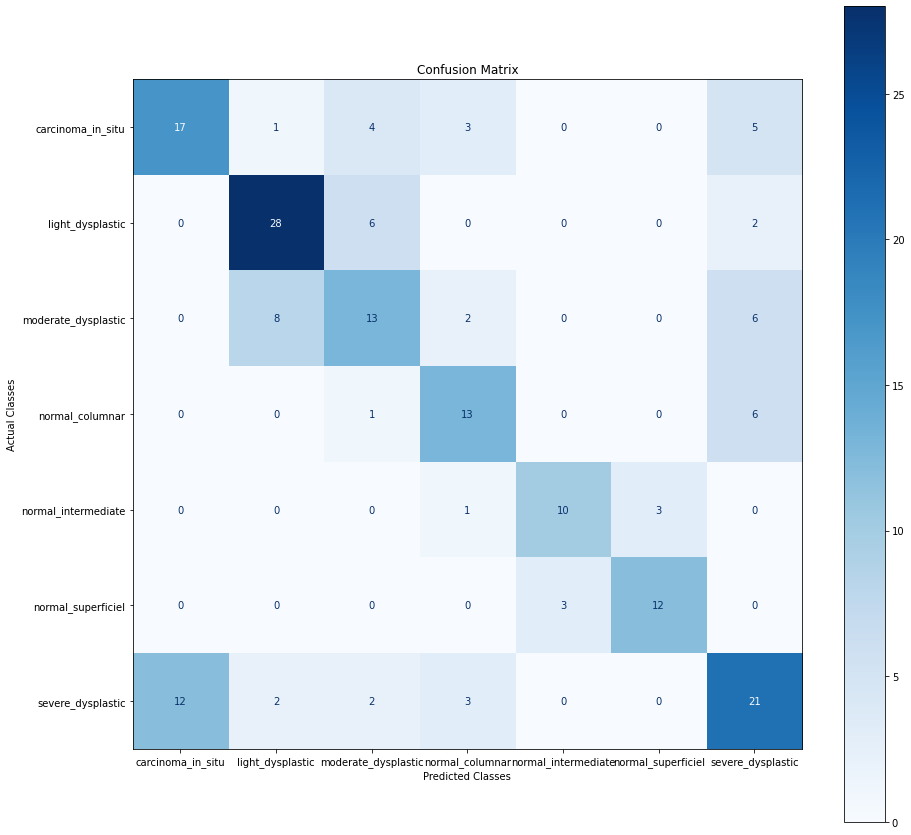

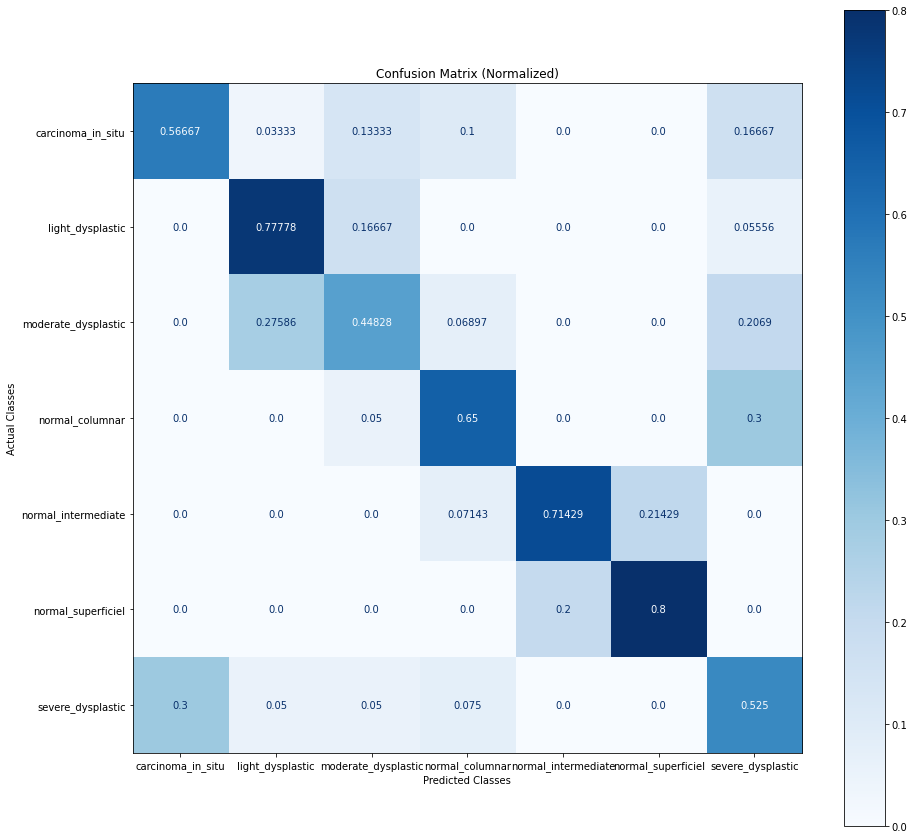

In [27]:
cm.plot(cmap=plt.cm.Blues, number_label=True);
cm.plot(cmap=plt.cm.Blues, number_label=True, normalized=True);

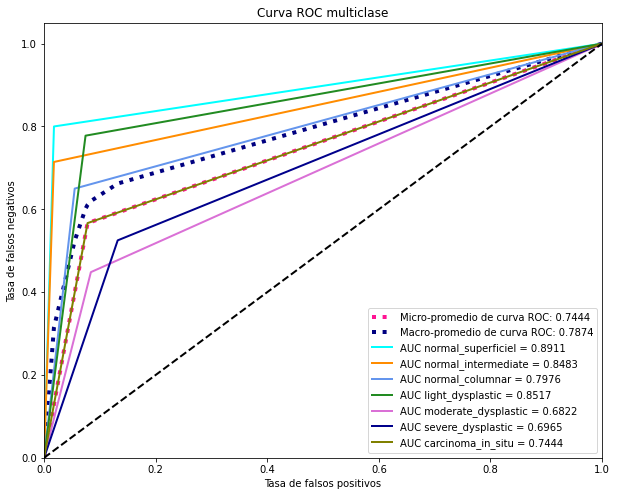

In [28]:
utils.plot_roc_multiclass(df_pred, class_list = df["Class_cat_7"].unique())

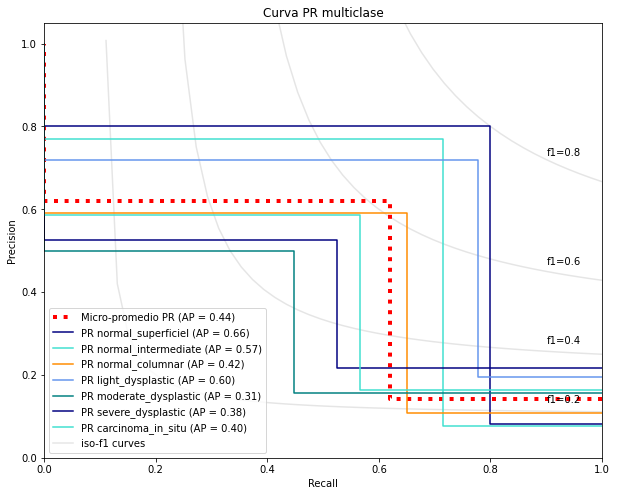

In [29]:
utils.plot_precision_recall_curve_multiclass(df_pred, class_list = df["Class_cat_7"].unique())